# Final Project - Sentiment Analysis
## Sarcasm on Reddit
###### source: https://www.kaggle.com/danofer/sarcasm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [5]:
#reading the csv file, parsing the dates (converting obj -> date type)
df = pd.read_csv("train-balanced-sarcasm.csv", parse_dates=['created_utc'])

#drop unnecessary 'date' column
df.drop('date', axis = 1, inplace = True)

#Improving the naming
df.rename(columns = {'created_utc':'date'}, inplace = True)
df.head()
#label 0 means non-sarcastic comment, label 1 means sarcastic. The original data has equal number of sarcastic and non-sarcastic comments. 
#The rest is self-explanatory

,label,comment,author,subreddit,score,ups,downs,date,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
df.shape 
#The dataset is too large, has more than million comments -> we can sample it

(1010826, 9)

In [7]:
df = df.sample(frac = 0.1, random_state = 1) 
#setting the seed and sampling the 10% of data

In [8]:
df['label'].describe() 
#even after sampling, the dataset is so big that the ratio of sarcastic to non-sarcastic comments stays almost the same (mean approximates 0.5)

count    101083.000000
mean          0.498739
std           0.500001
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

## Exploratory Analysis
### Insights

#### Which users have the most sarcastic comments?

In [9]:
df_only_sarcasm = df[df['label'] == 1]
df_only_sarcasm['author'].value_counts().nlargest(5)
#User Biffingston has 43 sarcastic comments

Biffingston       43
NeonDisease       29
pokemon_fetish    24
ShyBiDude89       19
mindlessrabble    18
Name: author, dtype: int64

#### Which subreddits include most sarcasm (measured with label mean)

In [10]:
df_large_subreddits = df[df.groupby("subreddit").subreddit.transform("size") >= 100] 
df_large_subreddits.groupby("subreddit")['label'].describe().sort_values(by = 'mean', ascending = False).head(10)
#creepyPMs is an absolute leader - around 79% of 581 comments posted are sarcastic.

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
creepyPMs,581.0,0.790017,0.407647,0.0,1.0,1.0,1.0,1.0
MensRights,328.0,0.695122,0.461059,0.0,0.0,1.0,1.0,1.0
Libertarian,242.0,0.665289,0.472867,0.0,0.0,1.0,1.0,1.0
facepalm,110.0,0.663636,0.474627,0.0,0.0,1.0,1.0,1.0
Conservative,218.0,0.655963,0.476146,0.0,0.0,1.0,1.0,1.0
worldnews,2677.0,0.652970,0.476114,0.0,0.0,1.0,1.0,1.0
Justrolledintotheshop,102.0,0.637255,0.483166,0.0,0.0,1.0,1.0,1.0
SubredditDrama,236.0,0.635593,0.482286,0.0,0.0,1.0,1.0,1.0
Roadcam,101.0,0.633663,0.484206,0.0,0.0,1.0,1.0,1.0


#### In which subreddits sarcastic comments are rated highest (in score)?

In [11]:
#Subsetting a dataframe from only_sarcasm with subreddits with more than 100 comments
subreddits_sarcasm_group = df_only_sarcasm[df_only_sarcasm.groupby("subreddit").subreddit.transform("size") >= 100].groupby("subreddit")

#1st method gives a general idea about those subreddits where the comments had the highest scores on average
#sarcastic comments in 'nottheonion' subreddit have highest average score. However, this measure is imperfect because the number of users/engagements are not taken into accounts 
print(subreddits_sarcasm_group['score'].describe().sort_values(by = 'mean', ascending = False).head(10))
print()

#2nd method shows the subreddits with highest median comment scores - a sarcastic comment on 'TrollXChromosomes' has a median score of 7.5
print(subreddits_sarcasm_group['score'].median().sort_values(ascending = False).head(10))

                   count       mean         std   min  25%  50%    75%     max
subreddit                                                                     
nottheonion        153.0  20.732026  151.449271 -17.0  1.0  2.0   5.00  1804.0
TrollXChromosomes  100.0  20.510000   45.112988  -6.0  3.0  7.5  17.25   287.0
relationships      115.0  19.017391   57.083193 -77.0  2.0  5.0  14.50   527.0
Android            177.0  13.915254   44.157372 -20.0  1.0  3.0  10.00   321.0
SubredditDrama     150.0  13.133333   35.271462 -22.0  2.0  4.0  11.00   323.0
creepyPMs          459.0  12.973856   31.459535 -13.0  3.0  6.0  13.00   544.0
MensRights         228.0  11.223684   38.124974 -33.0  1.0  3.0   7.00   404.0
smashbros          140.0  10.828571   31.649143 -13.0  1.0  3.0   7.00   308.0
cringepics         150.0  10.520000   27.459725 -31.0  1.0  2.0   7.00   197.0
news               984.0  10.446138  115.825416 -37.0  1.0  1.0   4.00  3219.0

subreddit
TrollXChromosomes    7.5
creepyPMs       

#### The worst sarcastic comment (lowest score)

In [12]:
worst_comment_score = np.min(df_only_sarcasm['score'])
df_only_sarcasm.loc[df_only_sarcasm.score==worst_comment_score]

,label,comment,author,subreddit,score,ups,downs,date,parent_comment
602862,1,Sarcasm doesn't translate well over the internet,QWERTYwarrior12,soccer,-107,-107,0,2015-09-19 14:44:40,How do you not realize he was sarcastic?


In [13]:
print("Subreddit: " + df_only_sarcasm['subreddit'][602862] + "\nParent Comment: " + df_only_sarcasm['parent_comment'][602862] + "\n" + "\n    Sarcastic Comment: " + df_only_sarcasm['comment'][602862])

Subreddit: soccer
Parent Comment: How do you not realize he was sarcastic?

    Sarcastic Comment: Sarcasm doesn't translate well over the internet


In [14]:
#The best sarcastic comment (highest score)

In [15]:
best_comment_score = np.max(df_only_sarcasm['score'])
df_only_sarcasm.loc[df_only_sarcasm.score == best_comment_score]
#okay :) 

,label,comment,author,subreddit,score,ups,downs,date,parent_comment
472388,1,It's only racist if a white person says it.,fuel_units,news,3219,3219,0,2016-04-06 01:20:49,That's racist as hell.


In [16]:
print("Subreddit: " + df_only_sarcasm['subreddit'][472388] + "\nParent Comment: " + df_only_sarcasm['parent_comment'][472388] + "\n" + "\n    Sarcastic Comment: " + df_only_sarcasm['comment'][472388])

Subreddit: news
Parent Comment: That's racist as hell.

    Sarcastic Comment: It's only racist if a white person says it.


### Visualizations

##### Is there a seasonality in sarcastic comments?

Text(0.5, 1.0, 'Is There a Seasonality in Sarcastic Comments?')

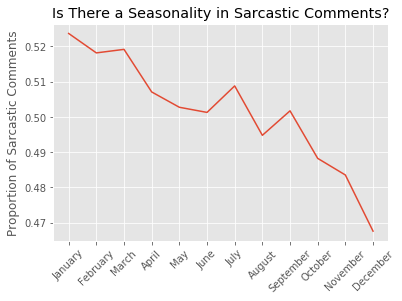

In [23]:
months = df.groupby(df['date'].dt.strftime('%B'))['label'].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = months.reindex(new_order, axis=0)
plt.plot(months)
plt.ylabel("Proportion of Sarcastic Comments")
plt.xticks(rotation=45)
plt.style.use('ggplot')
plt.title("Is There a Seasonality in Sarcastic Comments?")

#### Are sarcastic comments upvoted more (on average)?


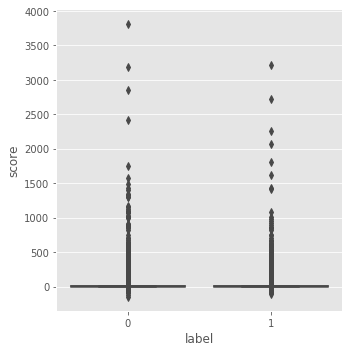

In [24]:
sns.catplot(x="label", y="score", kind="box", data=df)
#As expected, the median for both cases is closer to 0, implying that most of the comments have scores close to 0.
#The most interesting conclusion is that the Standard deviation of sarcastic comments is higher - good ones are getting higher scores while bad ones are being downvoted a lot. 

#### Wordlcoud for sarcastic comments

In [25]:
from wordcloud import WordCloud, STOPWORDS

In [26]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 10, width=800, height=400)

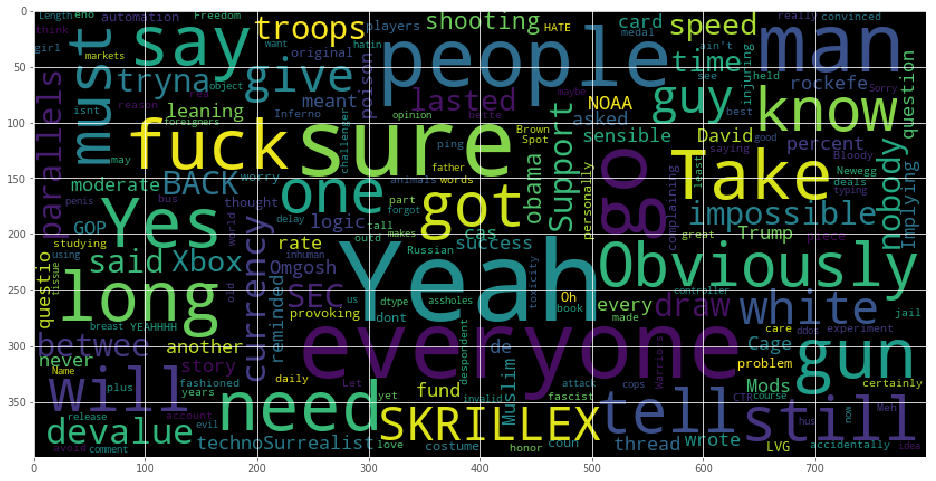

In [27]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud)
#Some of the words are expected: yeah, sure, yes, people, everyone, go
#Others are much more interesting: Skrillex, gun, lasted, long, parallels, technoSurrealist
#However, if we change the random_state, it is highly probable that we won't get those not-so-expected words

#### Wordlcoud for sarcastic comments (without generic words)

In [28]:
STOPWORDS.update(['Yes', 'will', 'de', 'Yeah', "take", 'give', 'still', 'got', 'one', 'need', 'tell', 'go', 'sure', 'know', 'say', 'guy', 'long', 'nobody', 'everyone', 'Obviously', 'must', 'man', 'people'])

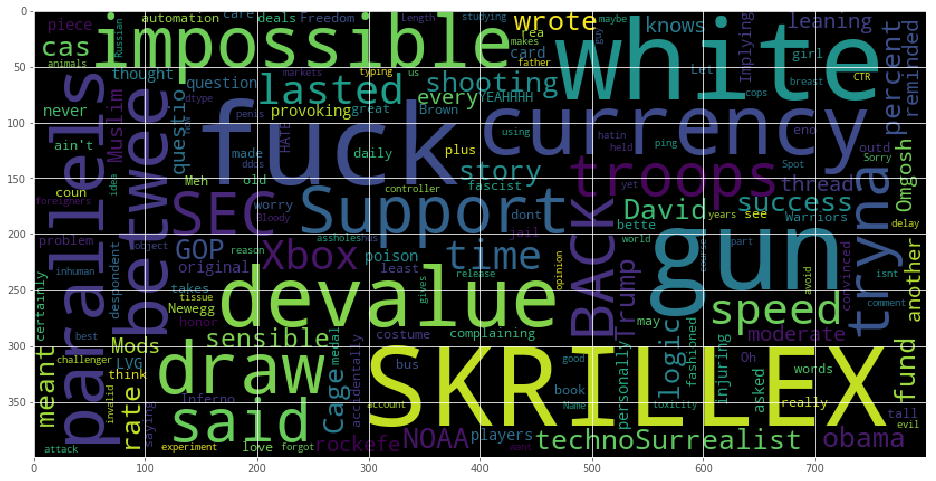

In [29]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud)

## Predictive Models
### Vader

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [31]:
#Separating the comments so that we can conduct a sentiment analysis
comment = df[['comment']]
comment = comment.dropna()

In [32]:
#generating a polarity score (i.e. compound) for each comment
comment['polarity_score']=comment['comment'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])

In [33]:
#creating a new column 'sentiment' based on the compund score (polarity score) - cutoff 0.05
comment['sentiment']=''
comment.loc[comment.polarity_score>0.05,'sentiment']='Positive'
comment.loc[(comment.polarity_score>-0.05) & (comment.polarity_score<0.05),'sentiment']='Neutral'
comment.loc[comment.polarity_score<-0.05,'sentiment']='Negative'

In [34]:
comment.head()

,comment,polarity_score,sentiment
317321,They need to devalue their currency for just t...,0.0000,Neutral
832274,Yes... impossible to draw any parallels betwee...,0.0000,Neutral
566130,"Support the troops, but nobody said we'd have ...",0.6249,Positive
261623,Like I said it was a strange choice.,0.1779,Positive
710273,The fuck you tryna say?,-0.5423,Negative


In [35]:
#adding the 2 calculated measures (polarity score and sentiment) to the primary dataset
df[['polarity_score', 'sentiment']]=comment[['polarity_score', 'sentiment']]
df.tail()

,label,comment,author,subreddit,score,ups,downs,date,parent_comment,polarity_score,sentiment
187179,0,It's important also that you make them feel in...,Se7enLC,LifeProTips,1,1,0,2016-07-03 18:14:25,"LPT: When someone asks you for help, show them...",0.1280,Positive
180755,0,Adjective noun is adjective,PraiseGeraldo,Gamingcirclejerk,1,-1,-1,2016-12-30 17:33:59,Following the Witcher page on facebook causes ...,0.0000,Neutral
447263,1,Must have been a ddos attack,wartortle87,CODZombies,8,8,0,2016-02-06 02:55:30,Another streamer got DC during the last step o...,-0.4767,Negative
331946,1,Yes because a penis and some breast tissue are...,whiterabbit_hansy,TwoXChromosomes,4,4,0,2016-06-19 10:15:29,Is it ok to walk around with massive erections...,0.4019,Positive
172806,1,You forgot the,obommer,politics,1,-1,-1,2016-10-08 10:32:35,Oh kids. You have no idea how the world works.,0.0000,Neutral


C:\Users\Asus UX310\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


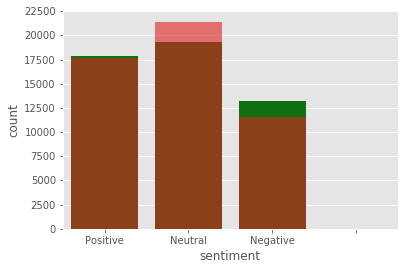

In [36]:
#adding the new columns to the dataframe with only sarcastic comments
df_only_sarcasm[['polarity_score', 'sentiment']]=comment[['polarity_score', 'sentiment']]

#subsetting a dataframe with only non-sarcastic comments
df_no_sarcasm = df[df['label'] == 0]
df_no_sarcasm[['polarity_score', 'sentiment']] = comment[['polarity_score', 'sentiment']]

#plotting
sns.countplot(x = 'sentiment', data = df_only_sarcasm, color='Green')
sns.countplot(x = 'sentiment', data = df_no_sarcasm, color = 'Red', alpha = 0.6)
plt.show()
#Overlaying the graphs against each other shows that there are more sarcastic comments with either positive or negative emotions, while there are fewer neutral sarcastic comments.

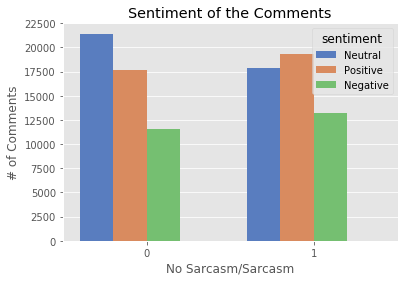

In [37]:
#Trying to get a similar result with the entire dataframe
plot = sns.countplot(x = 'label', hue = "sentiment", data = df, palette = "muted")
plot.set(xlabel='No Sarcasm/Sarcasm', ylabel='# of Comments', title = 'Sentiment of the Comments')
plt.show()
#This chart is more user-friendly. It conveys the same message as the previous one. Clearly, sarcastic comments have more 'emotion' in them - there are more both positive and negative comments.

### Extra -> Logistic Regression

#### Creating the Model

In [38]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [39]:
train_df = df
train_df.dropna(subset=['comment'], inplace=True)

In [40]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=10)

In [41]:
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range= (1, 2), max_features = 50000, min_df = 2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C = 1, n_jobs = 4, solver = 'lbfgs', 
                           random_state = 10, verbose = 1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [42]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 21.7 s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.3s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [43]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

Wall time: 1.37 s


In [44]:
accuracy_score(y_valid, valid_pred)

0.6941432528690147

#### Explaining the Model

In [45]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

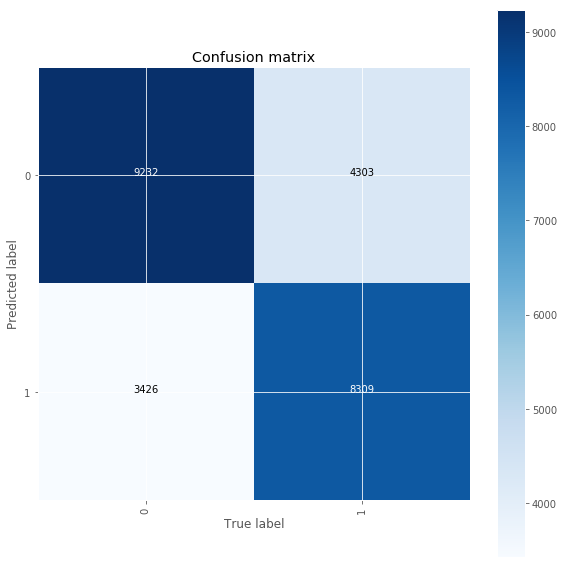

In [46]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [48]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Using TensorFlow backend.


Weight?,Feature
+6.003,yeah
+5.976,clearly
+5.623,because
+5.599,totally
+5.490,obviously
+4.613,yes because
+4.001,forgot
+3.587,racist
+3.520,sure
+3.424,shitlord
